# Imports

In [1]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# custom functions
from evaluation_functions import time_based_evaluation, evaluate_model_with_train
from pipeline_transformers import LogTransformer, FeatureCreation, FeatureRemoval

C:\Users\nbeha\AppData\Local\Temp\ipykernel_14904\2040165054.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data ingestion

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
valid = pd.read_csv('valid.csv')
all_data = pd.concat([train, test, valid])

# treatments applied to the training data (check EDA notebook for details)
train = train[train['general_a_vencer_weighted_periodo_div_pct_risco'] >= 0]

keys = ['fake_cnpj', 'date_reference']
target = 'TARGET_default_within_11m'

features = [
    'chk_esp_cred_rot_a_vencer_pct_risco',
    'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo',
    'cnt_declined_reasons',
    'days_since_oldest_board_member',
    'general_a_vencer_pct_risco',
    'general_a_vencer_weighted_periodo_div_pct_risco',
    'general_limite_de_cred_sum_pct_risco',
    'general_limite_trend_6mo',
    'general_lost_pct_cart_cred',
    'general_lost_pct_risco',
    'general_vencido_max_prev_6mo',
    'general_vencido_pct_carteira_cred__max_prev_6mo',
    'general_vencido_pct_risco_max_prev_6mo',
    'general_vencido_sum_sum_pct_risco',
    'v204r_is_popular_domain',
    'v254r_cnt_board_memebers',
    'years_since_first_relationship',
    'general_limite_de_cred_sum',
    'general_lost_sum',
    'general_vencido_sum'
    ]

# features that may induce bias/information from other models


# Model pipeline

## Baseline model

In [3]:
baseline_model = Pipeline([
    ('model', LGBMClassifier(random_state=5, verbose=-1))
])

all_columns = [c for c in train.columns if c not in keys + [target]]

baseline_model.fit(train[all_columns], train[target])
preds = baseline_model.predict_proba(test[all_columns])[:, 1]
train_preds = baseline_model.predict_proba(train[all_columns])[:, 1]

In [4]:
# Train
print('AUC:', roc_auc_score(train[target], train_preds))
print('Precision:', precision_score(train[target], train_preds > 0.5))
print('Recall:', recall_score(train[target], train_preds > 0.5))
print('Confusion Matrix:')
print(confusion_matrix(train[target], train_preds > 0.5))
print(confusion_matrix(train[target], train_preds > 0.5, normalize='true'))

AUC: 0.9990734509921454
Precision: 0.9986072423398329
Recall: 0.9041614123581336
Confusion Matrix:
[[4459    1]
 [  76  717]]
[[9.99775785e-01 2.24215247e-04]
 [9.58385876e-02 9.04161412e-01]]


In [5]:
# Test
print('AUC:', roc_auc_score(test[target], preds))
print('Precision:', precision_score(test[target], preds > 0.5))
print('Recall:', recall_score(test[target], preds > 0.5))
print('Confusion Matrix:')
print(confusion_matrix(test[target], preds > 0.5))
print(confusion_matrix(test[target], preds > 0.5, normalize='true'))

AUC: 0.8339451303918415
Precision: 0.547683923705722
Recall: 0.21883505715841045
Confusion Matrix:
[[15651   332]
 [ 1435   402]]
[[0.97922793 0.02077207]
 [0.78116494 0.21883506]]


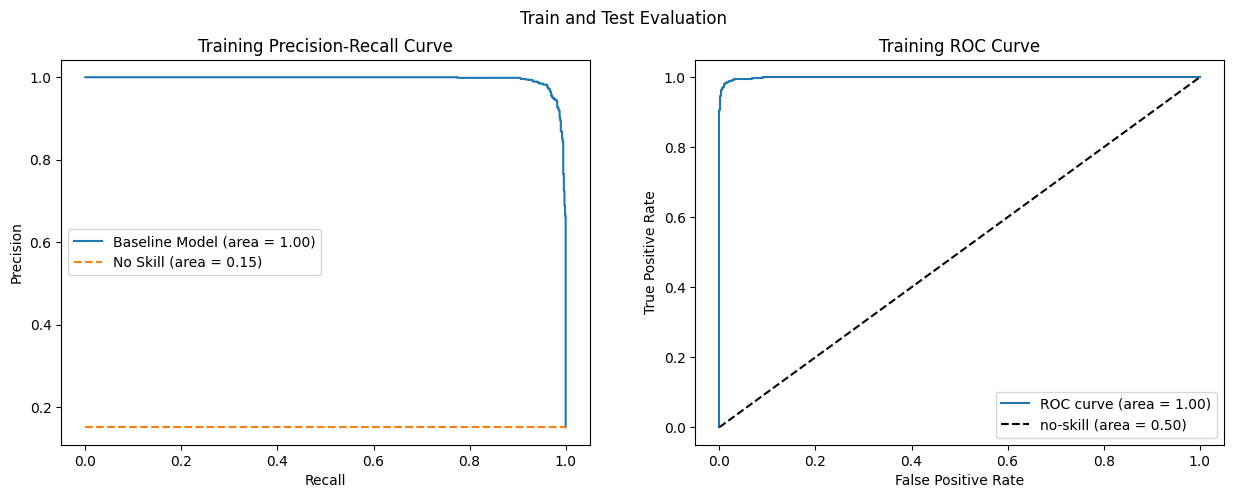

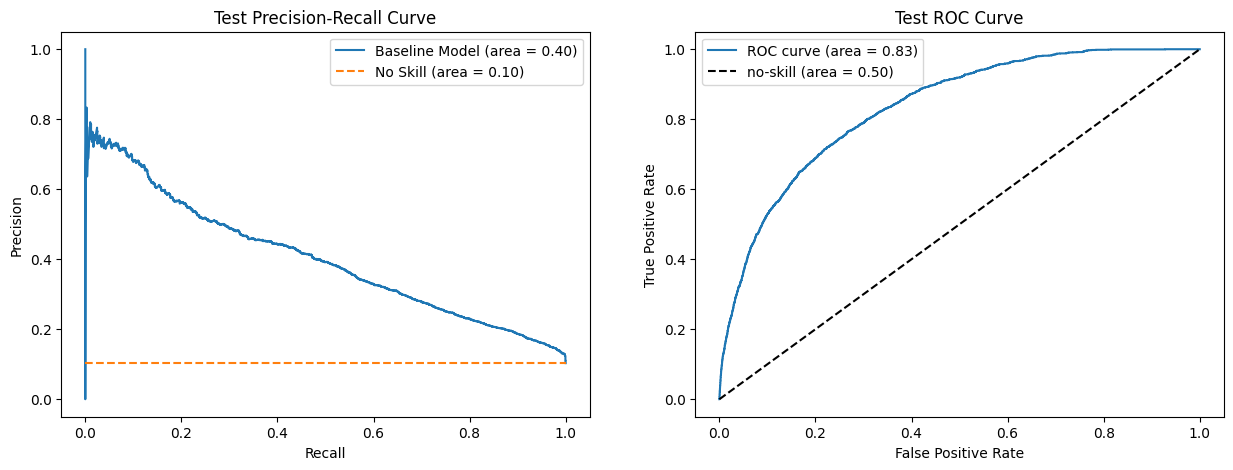

In [6]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

## Model with reduced feature set

In [7]:
log_transform_features = [
    'chk_esp_cred_rot_a_vencer_pct_risco',
    'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo',
    'general_limite_de_cred_sum',
    'general_limite_trend_6mo',
    'general_lost_pct_cart_cred',
    'general_lost_pct_risco',
    'general_lost_sum',
    'general_vencido_max_prev_6mo',
    'general_vencido_pct_carteira_cred__max_prev_6mo',
    'general_vencido_pct_risco_max_prev_6mo',
    'general_vencido_sum',
    'general_vencido_sum_sum_pct_risco']

model = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('lgbm', LGBMClassifier(max_depth=5, random_state=123, verbose=-1))
])

model.fit(train[features], train[target])
preds = model.predict_proba(test[features])[:, 1]
train_preds = model.predict_proba(train[features])[:, 1]

c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log1p(X[feature])
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["general_lost_sum__over__general_limite_de_cred_sum"] = (
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

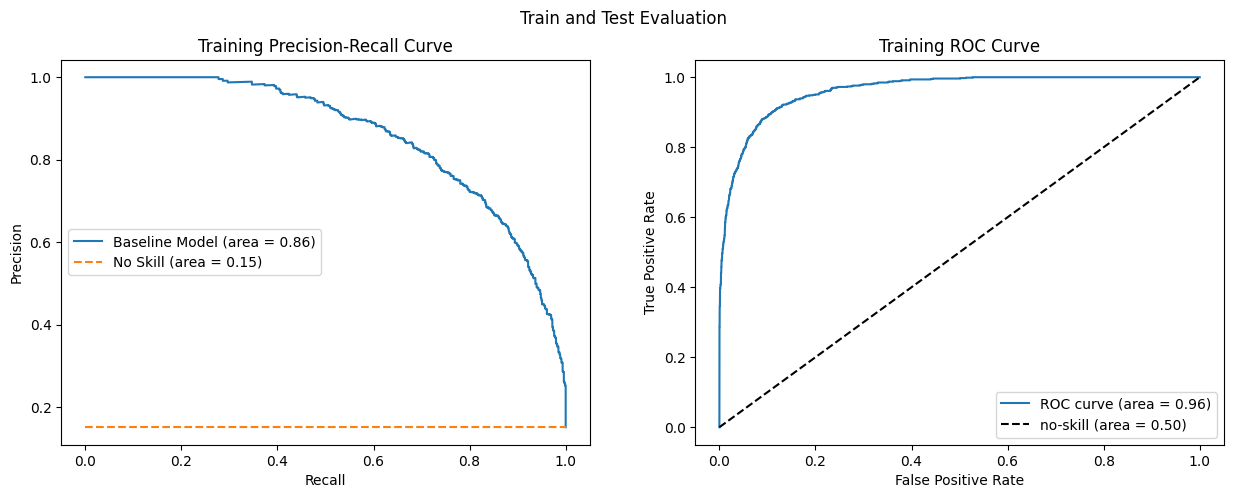

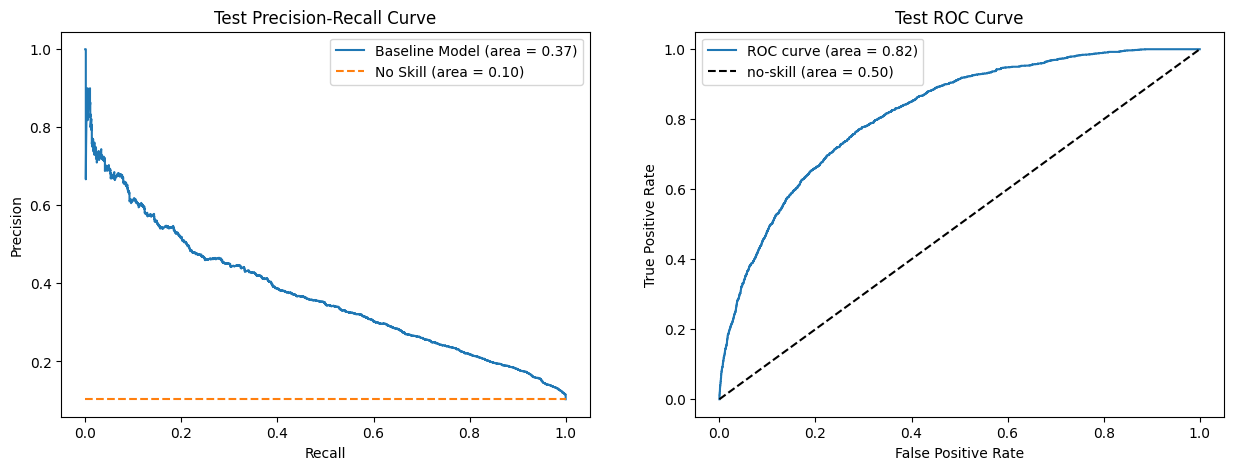

In [8]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

In [9]:
baseline_importances = pd.DataFrame(baseline_model[0].feature_importances_, index=all_columns, columns=['importance']).sort_values('importance', ascending=False)
new_importances = pd.DataFrame(model[3].feature_importances_, index=features, columns=['importance']).sort_values('importance', ascending=False)

In [10]:
baseline_importances.join(new_importances, how='outer', lsuffix='_baseline', rsuffix='_new').fillna(0).sort_values('importance_baseline', ascending=False)

,importance_baseline,importance_new
years_since_first_relationship,179,220.0
general_a_vencer_weighted_periodo_div_pct_risco,171,235.0
v001r_social_capital,153,0.0
general_limite_trend_6mo,147,175.0
general_a_vencer_under30d,144,0.0
days_since_oldest_board_member,142,158.0
min_lt_ir3_prev_6mo,141,0.0
special_inter_rate,140,0.0
primary_median_ir3_prev_6mo,131,0.0
chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo,129,167.0


In [11]:
# Altough some relevant features for the training dataset were removed in our EDA filter,
# the model still performs well in the test dataset

# Hyperparameter optimization

In [12]:
# def objective(trial):
#     param = {
#         'max_depth': trial.suggest_int('max_depth', 2, 5),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 10, 300),
#         'min_child_samples': trial.suggest_int('min_child_samples', 50, 100),
#         'subsample': trial.suggest_float('subsample', 0.1, 0.6),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
#     }
#     model = Pipeline([
#         ('log_transform', LogTransformer(log_transform_features)),
#         ('create_features', FeatureCreation()),
#         ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
#         ('lgbm', LGBMClassifier(**param, verbose=-1, random_state=123))
#     ], verbose=False)
#     model.fit(train[features], train[target])
#     preds = model.predict_proba(test[features])[:, 1]
#     return roc_auc_score(test[target], preds)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100, show_progress_bar=True)

# study.best_params


In [13]:
# best_params = study.best_params

best_params = {
 'max_depth': 5,
 'learning_rate': 0.04112868060463783,
 'n_estimators': 82,
 'min_child_samples': 66,
 'subsample': 0.2591667458499961,
 'colsample_bytree': 0.3607625455725305,
 'reg_alpha': 0.05864006204720501,
 'reg_lambda': 0.19828296427132538}

In [14]:
optimal_model = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('classifier', CalibratedClassifierCV(LGBMClassifier(**best_params, random_state=1), method='isotonic', cv=5)),
])

fitted_model = optimal_model.fit(train[features], train[target])
preds = fitted_model.predict_proba(test[features])[:, 1]
train_preds = fitted_model.predict_proba(train[features])[:, 1]

uncalibrated_optimal_model = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('classifier', LGBMClassifier(**best_params, random_state=1)),
])

uncalibrated_optimal_model.fit(train[features], train[target])
preds_wo_cal = uncalibrated_optimal_model.predict_proba(test[features])[:, 1]
train_preds_wo_cal = uncalibrated_optimal_model.predict_proba(train[features])[:, 1]

c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log1p(X[feature])
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["general_lost_sum__over__general_limite_de_cred_sum"] = (
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 634, number of negative: 3568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3659
[LightGBM] [Info] Number of data points in the train set: 4202, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.150881 -> initscore=-1.727712
[LightGBM] [Info] Start training from score -1.727712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log1p(X[feature])
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["general_lost_sum__over__general_limite_de_cred_sum"] = (
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 793, number of negative: 4460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3882
[LightGBM] [Info] Number of data points in the train set: 5253, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.150961 -> initscore=-1.727081
[LightGBM] [Info] Start training from score -1.727081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log1p(X[feature])
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["general_lost_sum__over__general_limite_de_cred_sum"] = (
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

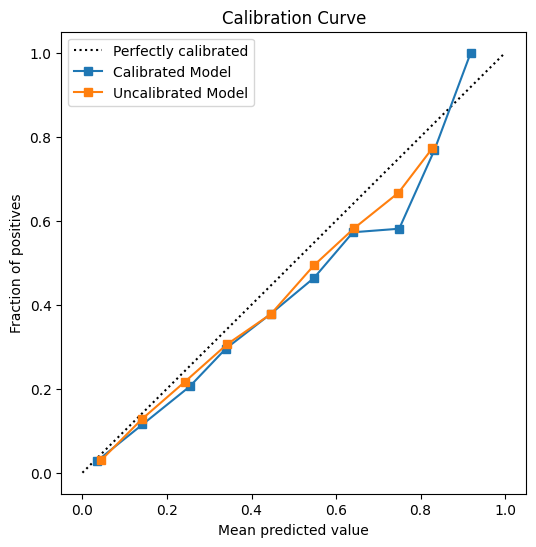

In [15]:
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives_wo_cal, mean_predicted_value_wo_cal = calibration_curve(test[target], preds_wo_cal, n_bins=10)
fraction_of_positives, mean_predicted_value = calibration_curve(test[target], preds, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibrated Model")
plt.plot(mean_predicted_value_wo_cal, fraction_of_positives_wo_cal, "s-", label="Uncalibrated Model")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title('Calibration Curve')
plt.legend()
plt.show()

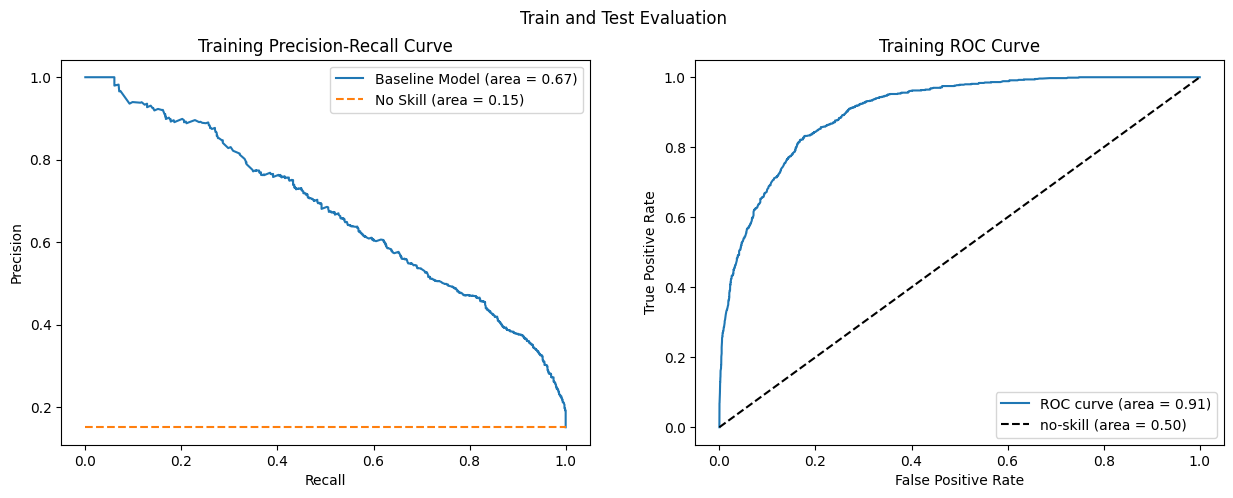

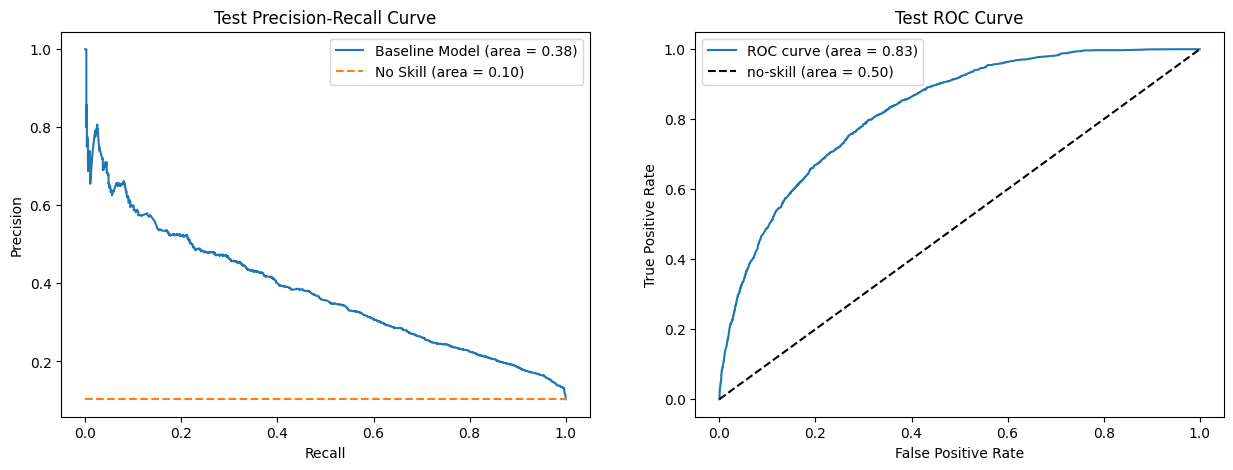

In [16]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

# SHAP Analysis

In [17]:
import shap
explainer = shap.TreeExplainer(uncalibrated_optimal_model[3])
shap_values = explainer.shap_values(test[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


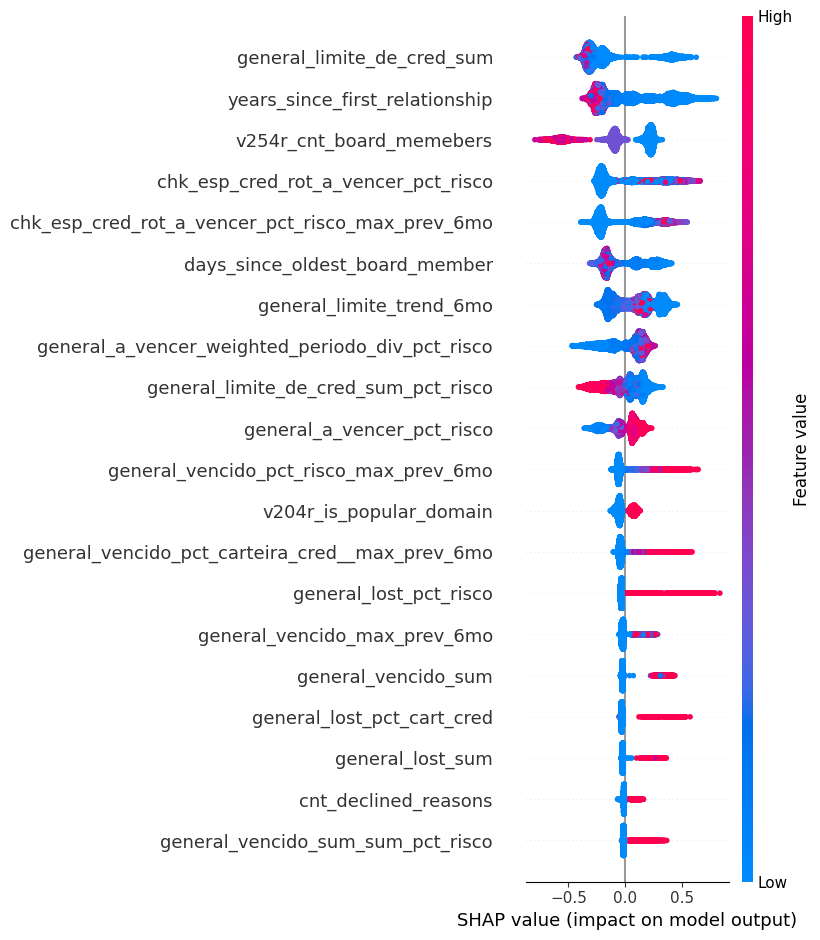

In [18]:
shap.summary_plot(shap_values[1], test[features])

In [19]:
# # Interaction between each feature pair
# for i in range(len(features)):
#     for j in range(len(features)):
#         if i != j:
#             print(f'Interaction between {features[i]} and {features[j]}')
#             shap.dependence_plot(ind=j, interaction_index=i, shap_values=shap_values[1], features=test[features], display_features=test[features], feature_names=features)


# Time-based Evaluation


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


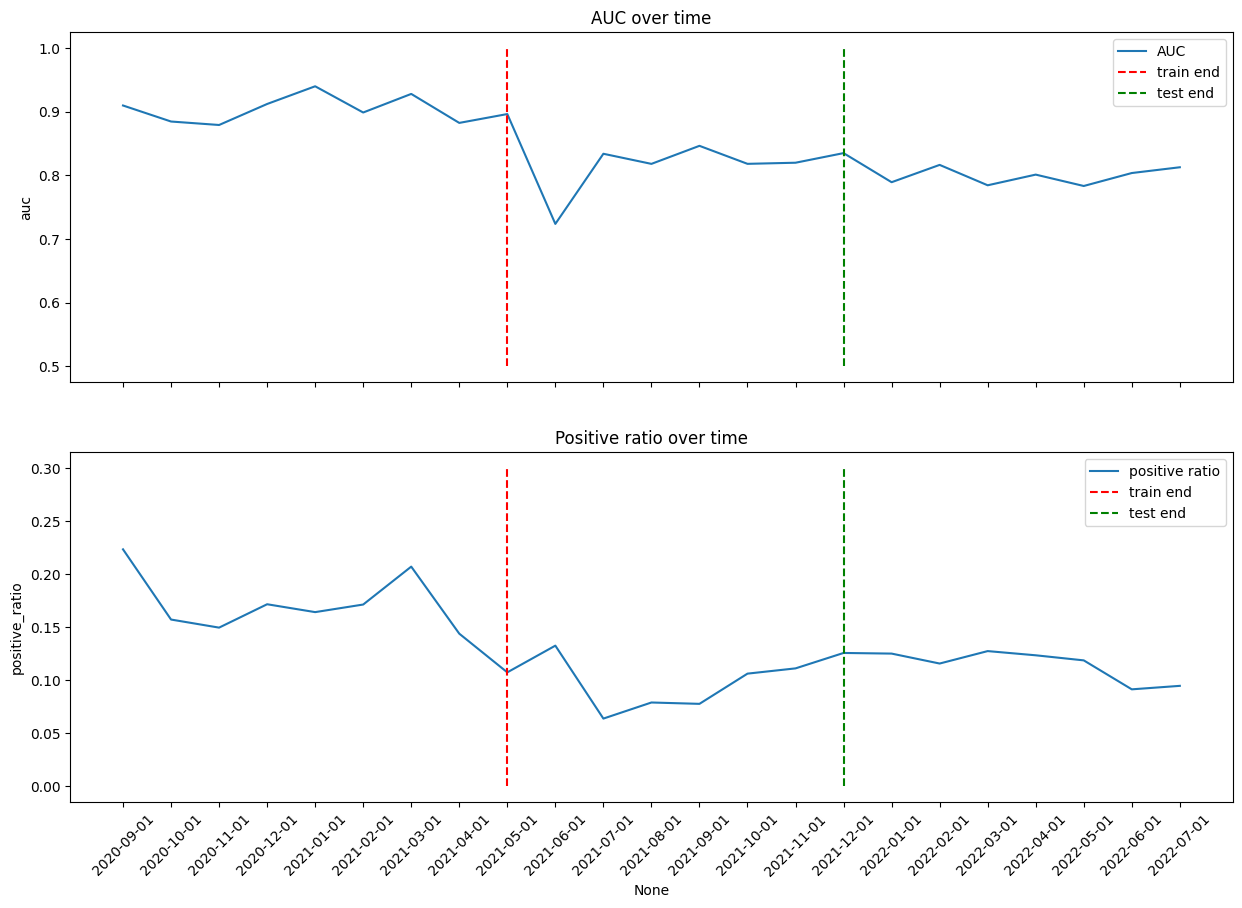

In [20]:
all_data['preds'] = optimal_model.predict_proba(all_data[features])[:, 1]
scored_df = time_based_evaluation(all_data, 'date_reference', target_col=target)

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

sns.lineplot(x=scored_df.index, y=scored_df['auc'], label='AUC', ax=ax[0])
ax[0].set_title('AUC over time')
ax[0].vlines(x=train['date_reference'].max(), ymin=0.5, ymax=1, color='r', linestyle='--', label='train end')
ax[0].vlines(x=test['date_reference'].max(), ymin=0.5, ymax=1, color='g', linestyle='--', label='test end')
ax[0].legend()

sns.lineplot(x=scored_df.index, y=scored_df['positive_ratio'], label='positive ratio', ax=ax[1])
ax[1].set_title('Positive ratio over time')
ax[1].vlines(x=train['date_reference'].max(), ymin=0, ymax=.3, color='r', linestyle='--', label='train end')
ax[1].vlines(x=test['date_reference'].max(), ymin=0, ymax=.3, color='g', linestyle='--', label='test end')
ax[1].legend()
ax[1].tick_params(axis='x', rotation=45)

plt.show()

# Saving the optimal model

In [21]:
# # saving the model into a pickle file
# import pickle
# with open('artifacts/model.pkl', 'wb') as f:
#     pickle.dump(fitted_model, f)

In [28]:
train[features].describe()

,chk_esp_cred_rot_a_vencer_pct_risco,chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo,cnt_declined_reasons,days_since_oldest_board_member,general_a_vencer_pct_risco,general_a_vencer_weighted_periodo_div_pct_risco,general_limite_de_cred_sum_pct_risco,general_limite_trend_6mo,general_lost_pct_cart_cred,general_lost_pct_risco,general_vencido_max_prev_6mo,general_vencido_pct_carteira_cred__max_prev_6mo,general_vencido_pct_risco_max_prev_6mo,general_vencido_sum_sum_pct_risco,v204r_is_popular_domain,v254r_cnt_board_memebers,years_since_first_relationship,general_limite_de_cred_sum,general_lost_sum,general_vencido_sum
count,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5.253000e+03,5253.000000,5253.000000,5.253000e+03,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5.253000e+03,5.253000e+03,5.253000e+03
mean,0.042868,0.096562,0.140682,5.336263,0.652915,0.006255,0.332945,2.129143e+03,0.003485,0.002982,1.486568e+04,0.041286,0.032546,0.002823,0.409480,1.740339,6.340759,2.173273e+05,2.933203e+03,1.992763e+03
std,0.143947,0.208579,0.367428,7.351487,0.334560,0.006076,0.335232,1.156968e+05,0.019798,0.012965,2.103746e+05,0.153910,0.131339,0.012493,0.491785,1.351132,7.842648,1.713023e+06,5.643044e+04,3.306596e+04
min,0.000000,0.000000,0.000000,-1.000000,0.000002,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,-0.076712,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.641096,0.377098,0.002330,0.036247,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.235616,2.068500e+03,0.000000e+00,0.000000e+00
50%,0.000000,0.002138,0.000000,2.865753,0.780745,0.004279,0.203676,9.720957e-01,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,3.361644,1.430125e+04,0.000000e+00,0.000000e+00
75%,0.006759,0.075843,0.000000,7.575342,0.946359,0.007963,0.601596,1.332320e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,2.000000,8.400000,6.658482e+04,0.000000e+00,0.000000e+00
max,1.000000,1.000000,2.000000,58.147945,1.000000,0.033333,0.999493,8.250000e+06,0.861395,0.099911,1.083299e+07,1.000000,1.000000,0.099417,1.000000,54.000000,57.054795,9.880121e+07,2.751284e+06,1.544033e+06


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
import numpy as np

class infinite_to_zero(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.replace([np.inf, -np.inf], 0)


logistic_model = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('infinite_to_zero', infinite_to_zero()), # replace infinite values with 0,
     # this case means that the customer doesnt have one of the engineered  components
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
    ('classifier', CalibratedClassifierCV(LogisticRegression(), method='isotonic', cv=5)),
])

logistic_model.fit(train[features], train[target])
preds = logistic_model.predict_proba(test[features])[:, 1]
train_preds = logistic_model.predict_proba(train[features])[:, 1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

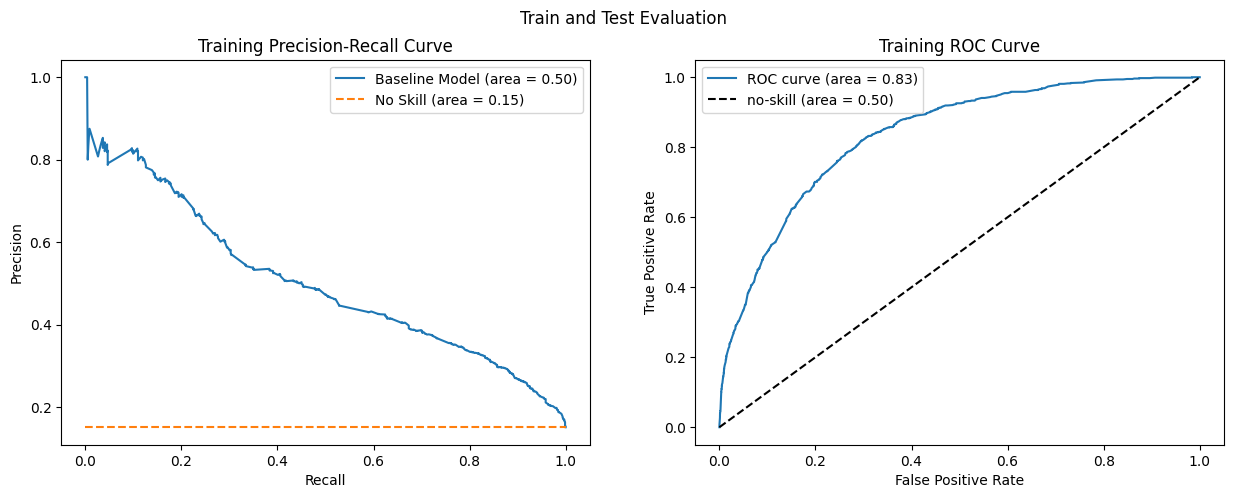

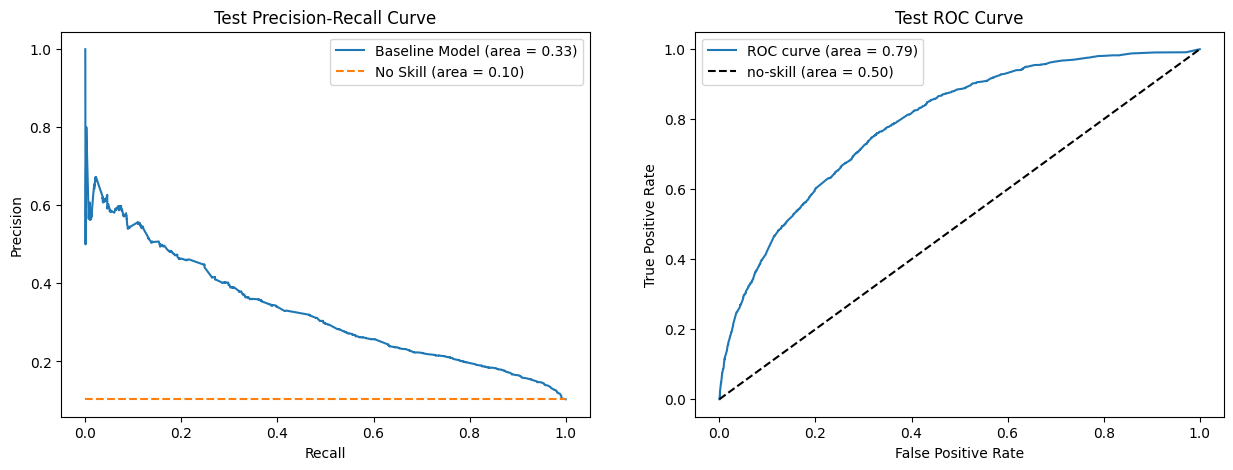

In [52]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)